# Semantic Analysis with LLMs<div class="tocSkip">

&copy; Jens Albrecht, 2023

This notebook can be freely copied and modified.
Attribution, however, is highly appreciated.

<hr/>

## Setup<div class='tocSkip'/>

Set directory locations. If working on Google Colab: copy files and install required libraries.

In [5]:
import sys, os
ON_COLAB = 'google.colab' in sys.modules

if ON_COLAB:
    GIT_ROOT = 'https://github.com/jsalbr/tdwi-2023-text-mining/raw/main'
    os.system(f'wget {GIT_ROOT}/notebooks/setup.py')

%run -i setup.py

0

You are working on Google Colab.
Files will be downloaded to "/content".
!wget -P /content/notebooks https://github.com/jsalbr/tdwi-2023-text-mining/raw/main/notebooks/settings.py
!wget -P /content/packages https://github.com/jsalbr/tdwi-2023-text-mining/raw/main/packages/cars.py
!wget -P /content/packages/blueprints https://github.com/jsalbr/tdwi-2023-text-mining/raw/main/packages/blueprints/__init__.py
!wget -P /content/packages/blueprints https://github.com/jsalbr/tdwi-2023-text-mining/raw/main/packages/blueprints/exploration.py
!wget -P /content/packages/blueprints https://github.com/jsalbr/tdwi-2023-text-mining/raw/main/packages/blueprints/preparation.py
!wget -P /content/packages/blueprints https://github.com/jsalbr/tdwi-2023-text-mining/raw/main/packages/blueprints/embeddings.py
!wget -P /content/data https://github.com/jsalbr/tdwi-2023-text-mining/raw/main/data/reddit-autos-selfposts-cleaned.csv
!wget -P /content/data https://github.com/jsalbr/tdwi-2023-text-mining/raw/main/dat

## Load Python Settings<div class="tocSkip"/>

Common imports, defaults for formatting in Matplotlib, Pandas etc.

In [6]:
%run "$BASE_DIR/notebooks/settings.py"

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'png'

# to print output of all statements and not just the last
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# otherwise text between $ signs will be interpreted as formula and printed in italic
pd.set_option('display.html.use_mathjax', False)
pd.options.plotting.backend = "matplotlib"

# path to import blueprints packages
sys.path.append(f'{BASE_DIR}/packages')

## Load Data

First, we create a subset of the data containing 500 samples of BMW, Volkswagen, and Tesla each.

In [7]:
df = pd.read_csv(f"{BASE_DIR}/data/reddit-autos-selfposts-prepared.csv", sep=";", decimal=".")

# add a column for the text length
df['len'] = df['text'].map(lambda t: len(t.split()))

# create a subset of the data containing 500 random samples from these subreddits
subreddits = ['BMW', 'Volkswagen', 'teslamotors']

# create initial empty dataframe
sample_df = df.query("subreddit == 'xxx'")[['id', 'subreddit', 'text', 'len']]

# add 500 samples for each subreddit
for subreddit in subreddits:
    subreddit_sample_df = df.query("subreddit == @subreddit and len > 80 and len < 500")[['id', 'subreddit', 'text', 'len']].sample(500)
    sample_df = pd.concat([sample_df, subreddit_sample_df])

sample_df.reset_index(inplace=True, drop=True)

# rename teslamotors to Tesla
sample_df['subreddit'] = sample_df['subreddit'].map(lambda s: 'Tesla' if s == 'teslamotors' else s)
df['subreddit']        = df       ['subreddit'].map(lambda s: 'Tesla' if s == 'teslamotors' else s)

# save samples
# sample_df.to_json('reddit-autos-selfposts-gpt-sentiment-samples.json', orient='records')

In [10]:
sample_df = pd.read_json(f'{BASE_DIR}/data/reddit-autos-selfposts-gpt-sentiment-samples.json', orient='records')

sample_df.groupby('subreddit')\
         .agg(count=('id', 'count'),
              avg_words=('len', 'mean'))

,count,avg_words
subreddit,,
BMW,500,146.92
Tesla,500,158.42
Volkswagen,500,143.12


In [11]:
pd.set_option('display.max_colwidth', None)
sample_df.sample(5)
pd.set_option('display.max_colwidth', 200)

,id,subreddit,text,len
398,l180j1,BMW,"M-Sport steering wheel for my F30 328i Sport advice: The F30 328i I currently daily has the Sport Automatic Transmission with Paddle Shifters (which it doesn't have heating functions). I'm still debating on bolt ons for the N26, such as the AWE quad exhaust system, but not at the moment, as the post is pertaining to the steering wheel at hand. Contemplating on whether I should swap out for the M-Sport wheel or keep the wheel I have, seeing as I'm reading that it may need to be rewired, new airbag unit, or something of the sort in addition. For those who installed it on other trims, what is your advice?",111
393,n1emrk,BMW,"Lost my F10 535d :(: I was saving money for so long, trying to get my dream car, then for 3 months I could not believe I had it.... A few days ago, the car was stolen from a parking lot with video surveillance in the center of my city Copenhagen and of course the police doesn't care. I am devastated, it was such a rare and special car...I used all my savings on it.. Sorry if this is against the rules....I am so exhausted. How do you cope with these kind of stuff...every bmw i see now is a huge trigger..",102
787,l4jgay,Volkswagen,"Golf 8 eTSI DSG Gearbox: Hi guys ! I'm thinking of ordering a Golf 8 eTSI 1.5 (automatic) and I have a couple of questions if you can help me out: 1. Do we know which DSG model the new eTSI uses ?? From what I've read, the worst one is the DQ200 (dry clutch). Is that the model in the new Golf are have they replaced it with something better ? (wet clutch) 2. Are the new DSGs reliable (even the DQ200) or should I be worried after 5-10 years ?? Thank you in advance !",97
626,mxx8zz,Volkswagen,"New here, question: So I just got the SE V6 R line Atlas cross sport. I am coming from a Jeep Compass (v4) and I feel like when I am driving I can feel the gears switch. Is this normal? It's almost like it's in sport mode but it's not. I don't know if it's because I'm just sensitive to the bigger engine/heavier car or if it warrants me bringing it in. It feels like a LITTLE jolt or kick back when I accelerate and when I am breaking it's not entirely too smooth. Just wondering if this is just the engine or an issue on my brand new car lol, just got it yesterday.",115
937,l6wzyt,Volkswagen,"2017 Alltrack Decision: Hello Everyone! I purchased a 2017 Alltrack recently in December and somehow never heard of the roof issues. I'm petrified of others have experiences. The car has about 45k on it and drives like a dream. I bought this a vehicle that gets good gas mileage, is fun to drive, has some extra room, for long trips to family and to travel as my girlfriend has a traveling job. Given as these issues are common, I have decided to take the loss and get rid of the vehicle. That said... I really love the vehicle otherwise. Haven't had it in the rain to know if it has the issues common to the vehicles. Had the drains cleaned out and tested and the shop said they are ok. Has anyone experience these issues with the non sunroof cars? My other option would be to do a golf R and take the hit on space and dirt road driving capabilities. Probably do a roof rack. What's everyone's opinion?",169


## OpenAI

In [14]:
!pip install python-dotenv


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
import os
from dotenv import load_dotenv
load_dotenv('.env')
# os.environ['OPENAI_API_KEY'] = "YOUR API KEY"

False

In [16]:
import openai

openai.api_key = os.environ['OPENAI_API_KEY']

openai_models = openai.Model.list()
models_df = pd.DataFrame(openai_models['data'])

models_df[['id', 'root', 'parent']]

,id,root,parent
0,whisper-1,whisper-1,None
1,babbage,babbage,None
2,davinci,davinci,None
3,text-davinci-edit-001,text-davinci-edit-001,None
4,babbage-code-search-code,babbage-code-search-code,None
5,text-similarity-babbage-001,text-similarity-babbage-001,None
6,code-davinci-edit-001,code-davinci-edit-001,None
7,text-davinci-001,text-davinci-001,None
8,ada,ada,None
9,gpt-4-0613,gpt-4-0613,None


In [18]:
prompt = "Explain the term Business Intelligence with a joke in at most 100 words!"

In [20]:
# Instruction / completion model
response = openai.Completion.create(
  model="text-davinci-003",
  prompt=prompt,
  max_tokens=200
)

print(response['choices'][0]['text'])



Business Intelligence is like a GPS system for your business - it helps you get to where you want to go! A joke about it would be: Boss: "I'm not sure how to increase my sales!" Business Intelligence: "Just turn left at the 'Profits' Avenue, and you'll be there in no time!"


In [19]:
# Chat model
response = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=[
        #{"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt}
        #{"role": "assistant", "content": "..."},
        #{"role": "user", "content": "..."}
    ]
)

print(response['choices'][0]['message']['content'])

Why did the business manager break up with her data analyst boyfriend? Because he always kept telling her "It's not you, it's just my BI dashboard giving me some alarming KPIs".


## Langchain

In [21]:
from langchain.llms import OpenAI

llm = OpenAI(model_name="gpt-3.5-turbo", temperature=1) # temp between 0 (more rigid) and 2 (more flexible)
print(llm(prompt))

Why did the business analyst break up with the data? They didn't have good BI-lateral communication.


In [22]:
# more rigid model
llm = OpenAI(model_name="gpt-3.5-turbo", temperature=0.2)

In [23]:
text = """
A few weeks ago I got a 2019 BMW 440i.
CarPlay worked flawlessly for the first month but out of no where I'm having serious problems.
At least the panoramic sunroof works fine, and I love it.
"""

In [24]:
text = """
I love my BMW i3 because it has a really strong engine for such a small car.
But the battery could be stronger. We used to have a 2003 Audi A4 cabriolet
which was very reliable but had problems with the sun roof.
"""

In [25]:
template = """
The following text is about a car and its components.
Identify the vendor, the car model, the components and the mentioned sentiment.

Text: {text}
"""

In [26]:
llm = OpenAI(model_name="gpt-3.5-turbo", temperature=0.2)
prompt = template.format(text=text)
print(llm(prompt))

Vendor: BMW
Car model: i3
Components: engine, battery, sun roof
Sentiment: Positive (for the engine) and negative (for the battery and sun roof)


In [28]:
from langchain import PromptTemplate

llm = OpenAI(model_name="text-davinci-003", temperature=0.2)

# instruction model: probably better but slower and more expensive
# llm = OpenAI(model_name="text-davinci-003", temperature=1)

template = """

Instruction: The text following the three dashes is about cars and their components.
Extract a list in json format where each entry includes the mentioned car component or part,  the corresponding sentiment as "positive" or "negative", the respective car brand, the car model, and the year of making if specified.
Do not generate entries with neutral or no sentiment.
If a model name starts with a year, remove it from the model name and put it into a separate json field.
If there is no vendor mentioned, assume it is {subreddit}.
Each entry in the json list should have the fields "model", "vendor", "part", "sentiment", and "year".

---

Text: {text}
"""

prompt_template = PromptTemplate.from_template(template)

prompt = prompt_template.format(subreddit="BMW", text=text)
print(prompt)

print("-"*40)
print("Output: ")
print(llm(prompt, max_tokens=512))



Instruction: The text following the three dashes is about cars and their components. 
Extract a list in json format where each entry includes the mentioned car component or part,  the corresponding sentiment as "positive" or "negative", the respective car brand, the car model, and the year of making if specified.
Do not generate entries with neutral or no sentiment.
If a model name starts with a year, remove it from the model name and put it into a separate json field. 
If there is no vendor mentioned, assume it is BMW.
Each entry in the json list should have the fields "model", "vendor", "part", "sentiment", and "year".

---

Text: 
I love my BMW i3 because it has a really strong engine for such a small car. 
But the battery could be stronger. We used to have a 2003 Audi A4 cabriolet 
which was very reliable but had problems with the sun roof.


----------------------------------------
Output: 


[
  {
    "model": "i3",
    "vendor": "BMW",
    "part": "engine",
    "sentiment": "p

In [29]:
post_ids = ['kp6h39', 'kqapvo']

# iter_df = sample_df.sample(3)
iter_df = sample_df.query("id.isin(@post_ids)")

for index, row in tqdm(iter_df.iterrows(), total=len(iter_df)):
    # print(row['text'])
    id = row['id']
    subreddit = row['subreddit']
    text = row['text']
    prompt = prompt_template.format(subreddit=subreddit, text=text)
    output = llm(prompt, max_tokens=512)

    print("TEXT:")
    print(text)
    print("\nOUTPUT:")
    print(output)
    print('-'*40)

  0%|          | 0/2 [00:00<?, ?it/s]

TEXT:
2.5L Golf... vacuum pump leaking oil? Help??: I have a 2012 2.5L Golf, which I love dearly, that has a leaky vacuum pump. The dealer wants $1600 to replace the pump, but I know from doing some research that that is because they want to drop the transmission to do the repair despite the fact that it can *technically* be done without it. Seems like some people have also had luck just replacing the seals and not the whole pump. So, while I am mechanically minded enough to understand that this may be true, I'm definitely not skilled enough to do the work myself. Anyone in the New England area (I'm just outside Boston) particularly handy and willing to help a stranger out? I'm happy to come to you and pay I just think $1600 is a little excessive. Alternatively, has anyone had this work done at a shop in this area for less than $1600? ​ Help me r/volkswagen you're my only hope.

OUTPUT:

[
    {
        "model": "2.5L Golf",
        "vendor": "Volkswagen",
        "part": "vacuum pump"

In [ ]:
import json
from json import JSONDecodeError

file = open("reddit-autos-selfposts-gpt-sentiment.json", "w")

iter_df = sample_df # [0:100]

for index, row in tqdm(iter_df.iterrows(), total=len(iter_df)):
    # print(row['text'])
    id = row['id']
    subreddit = row['subreddit']
    text = row['text']
    prompt = prompt_template.format(subreddit=subreddit, text=text)

    # print(text)

    try:
        output = llm(prompt, max_tokens=512)

        output_json = json.loads(output)

        # Append-adds at last
        for j in output_json:
            j['subreddit'] = subreddit
            j['id'] = id
            _ = file.write(json.dumps(j)+"\n")
        file.flush()

        # print(text)
        # print(output)
        # print('\n'*2)

    except JSONDecodeError as e:
        print("JSONDecodeError: " + e.msg)
        print(f"ID: {id} ({subreddit})")
        print(output)
        print("-"*40)
        pass

    except Exception as e:
        print(f"Exception: {type(e)}")
        print(f"ID: {id} ({subreddit})")
        print("-"*40)
        pass


file.close()



## Post Processing LLM Output

In [32]:
sent_df = pd.read_json(f'{BASE_DIR}/data/reddit-autos-selfposts-gpt-sentiment.json', lines=True)

In [ ]:
sent_df.count().T

model              3582
vendor             3597
part               3639
sentiment          3642
year               3029
subreddit          3642
id                 3642
value                 4
message               1
description           4
note                  1
additional_info       1
dtype: int64

In [33]:
sent_df.query('value.notnull()')

,model,vendor,part,sentiment,year,subreddit,id,value,message,description,note,additional_info
374,M3 Comp,BMW,color,negative,2021,BMW,lfsfh8,Sao Paulo Yellow,NaN,NaN,NaN,NaN
375,M3 Comp,BMW,upholstery,neutral,2021,BMW,lfsfh8,Yas Marina Blue/Black,NaN,NaN,NaN,NaN
376,M3 Comp,BMW,color,positive,2021,BMW,lfsfh8,Portimao Blue,NaN,NaN,NaN,NaN
377,M3 Comp,BMW,upholstery,positive,2021,BMW,lfsfh8,Kyalami orange,NaN,NaN,NaN,NaN


In [34]:
# drop unused columns
sent_df = sent_df[['id', 'subreddit', 'vendor', 'model', 'year', 'part', 'sentiment']]

## Visual Exploration of Examples

### Define Functions for Highlighting

In [35]:
from IPython.display import display, HTML

def print_highlighted(text, model_parts):

    colors = ['#00AAFF', '#FF00FF', '#FFAA00']
    synonyms = {'reliable': 'reliability',
                'stable': 'stability'}
    for k, v in synonyms.copy().items():
        synonyms[v] = k
    html = text
    for i, model in enumerate(model_parts):
        color = colors[i] if i < len(colors) else colors[0]
        html = html.replace(model, f'<span style="background-color: {color}">{model}</span>')
        html = html.replace(model.lower(), f'<span style="background-color: {color}">{model}</span>')

        for part in model_parts[model]['part']:
            html = html.replace(part, f'<span style="color: {color}">{part}</span>')
            if part in synonyms:
                syno = synonyms[part]
                html = html.replace(syno, f'<span style="color: {color}">{syno}</span>')

    display(HTML(html))


def display_parts(id):

    # display(HTML(f'<strong>Selfpost: {id}</strong>'))
    display(sent_df.query('id == @id')[['id', 'vendor', 'model', 'year', 'part', 'sentiment']])
    text = df.query('id == @id').text.values[0]

    model_parts = sent_df.query('id == @id').groupby('model').agg({"part": list}).to_json(orient='index')
    model_parts = json.loads(model_parts)

    print_highlighted(text, model_parts)

### Examples

In [36]:
id = sent_df.sample(1).id.values[0]
# id = 'lxip4d'
id = 'myocvt'

display_parts(id)

,id,vendor,model,year,part,sentiment
221,myocvt,BMW,428i xDrive AWD,2014,timing chain,negative
222,myocvt,BMW,428i xDrive AWD,2014,oil changes,positive
223,myocvt,BMW,428i xDrive AWD,2014,new tires,positive
224,myocvt,BMW,428i xDrive AWD,2014,coolant,positive


In [37]:
id = 'n8unhf'
display_parts(id)

,id,vendor,model,year,part,sentiment
179,n8unhf,BMW,X3,2018,equalizer,negative
180,n8unhf,unknown,Volvo,None,sound system,positive


In [38]:
# Hallucination - this post says nothing about transmission or engine
# but only "from a quick inspection everything seemed good"
id = 'mxyt0d'
display_parts(id)

,id,vendor,model,year,part,sentiment
960,mxyt0d,BMW,745li,2003,center console,negative
961,mxyt0d,BMW,745li,2003,driver side door sill,negative
962,mxyt0d,BMW,745li,2003,engine,positive
963,mxyt0d,BMW,745li,2003,transmission,positive


In [39]:
id = 'mmjbbl'
display_parts(id)

,id,vendor,model,year,part,sentiment
647,mmjbbl,BMW,X5 x50i,2015,drivetrain,negative
648,mmjbbl,BMW,X5 x50i,2015,auto stop,positive


In [40]:
id = 'nkz7e7'
display_parts(id)

,id,vendor,model,year,part,sentiment
1637,nkz7e7,Volkswagen,Passat,2012,arb,negative
1638,nkz7e7,Volkswagen,Passat,2012,airbag,negative
1639,nkz7e7,Volkswagen,Passat,2012,traction,negative


In [41]:
id = 'nkz7e7'
display_parts(id)

,id,vendor,model,year,part,sentiment
1637,nkz7e7,Volkswagen,Passat,2012,arb,negative
1638,nkz7e7,Volkswagen,Passat,2012,airbag,negative
1639,nkz7e7,Volkswagen,Passat,2012,traction,negative


In [42]:
id = 'n0d6s4'
display_parts(id)

,id,vendor,model,year,part,sentiment
1070,n0d6s4,BMW,X7,None,seats,positive
1071,n0d6s4,GMC,Yukon Denali,None,function and space,positive
1072,n0d6s4,Toyota,Land Cruiser,None,function and space,positive
1073,n0d6s4,Volvo,XC90,None,function and space,positive
1074,n0d6s4,BMW,i40,None,driving experience,positive


In [43]:
id = 'n22u29'
display_parts(id)

,id,vendor,model,year,part,sentiment
3424,n22u29,Tesla,Model 3,2022,battery,positive
3425,n22u29,Toyota,LS430,2005,reliability,positive
3426,n22u29,Tesla,Model 3,2022,federal rebates,positive


In [44]:
id = 'li3b6n'
display_parts(id)

,id,vendor,model,year,part,sentiment
2517,li3b6n,Volkswagen,Jetta,2019,stability,positive
2518,li3b6n,Volkswagen,Golf,2018,stability,positive


## Explorative Data Analysis

In [45]:
sent_df.describe().T

,count,unique,top,freq
id,3642,1122,n6m7bj,11
subreddit,3642,3,BMW,1342
vendor,3597,68,BMW,1271
model,3582,749,Model 3,236
year,3029,171,,353
part,3639,2188,engine,116
sentiment,3642,5,positive,1946


In [46]:
sent_df.isnull().sum()

id             0
subreddit      0
vendor        45
model         60
year         613
part           3
sentiment      0
dtype: int64

In [47]:
sent_df = sent_df.dropna(subset = ['vendor'])
sent_df.isnull().sum()

id             0
subreddit      0
vendor         0
model         30
year         572
part           3
sentiment      0
dtype: int64

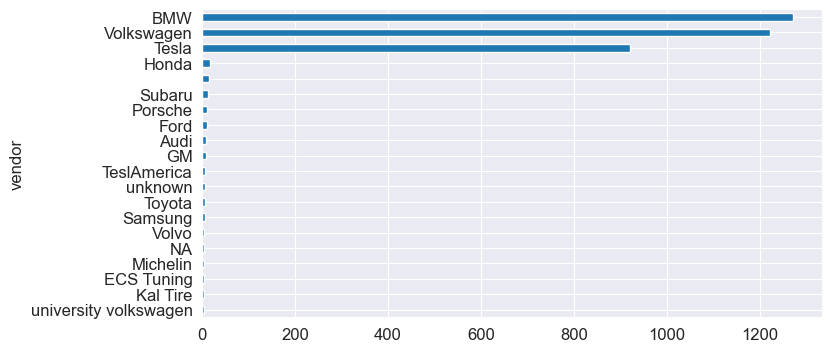

In [ ]:
pd.set_option('display.max_rows', 200)

sent_df['vendor'].value_counts().head(20).plot(kind='barh').invert_yaxis()

In [48]:
from blueprints.exploration import wordcloud

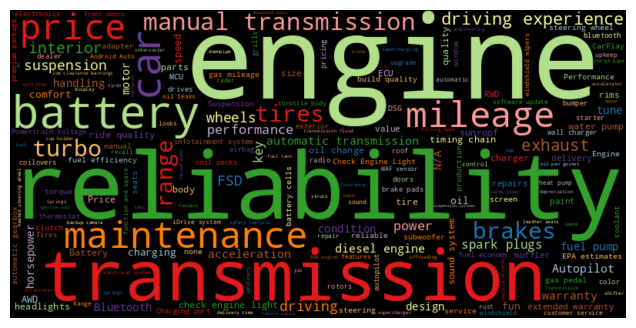

In [49]:
wordcloud(sent_df['part'].value_counts())

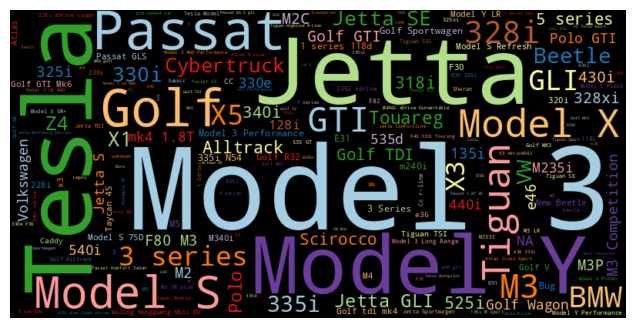

In [50]:
wordcloud(sent_df['model'].value_counts())

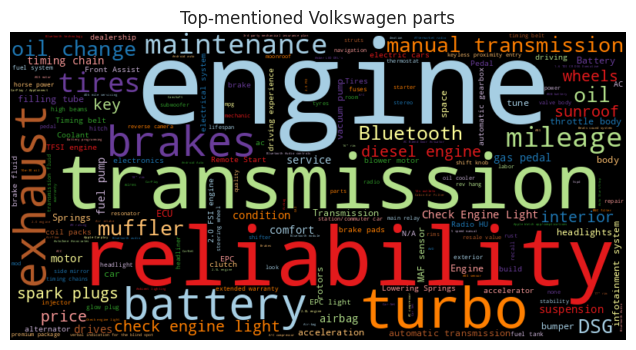

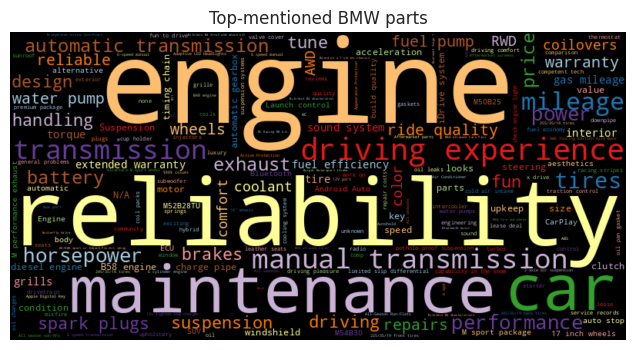

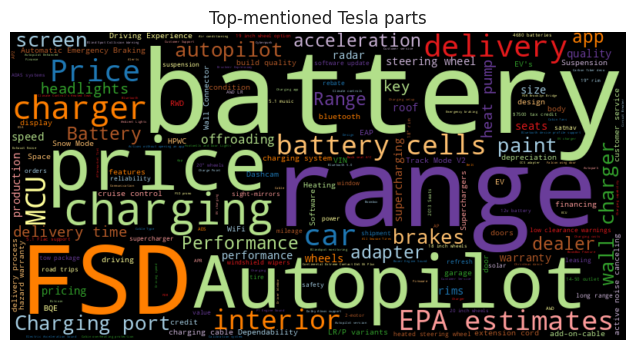

In [51]:
for vendor in ['Volkswagen', 'BMW', 'Tesla']:
    tmp_df = sent_df.query('vendor == @vendor')

    # tmp_df = tmp_df.query('model.str.contains("Golf")')
    part_counts = tmp_df.groupby('part').id.count()
    wordcloud(part_counts, title=f"Top-mentioned {vendor} parts")
    plt.show()

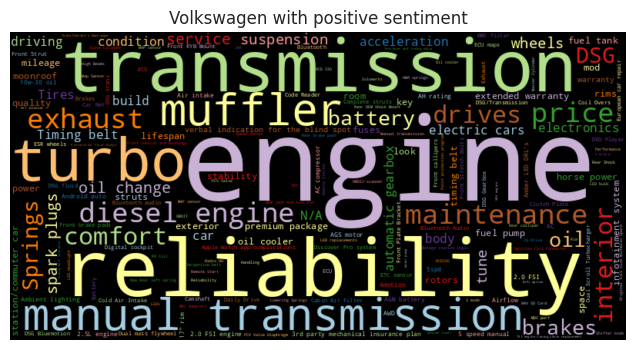

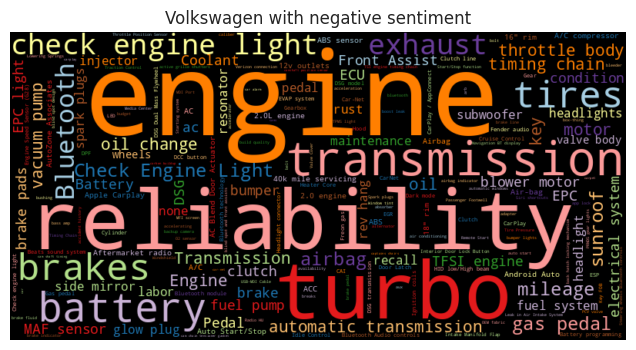

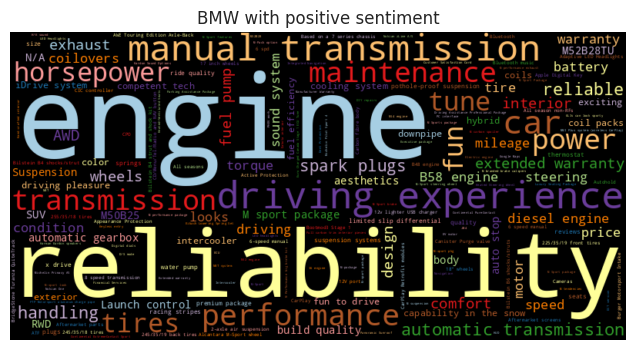

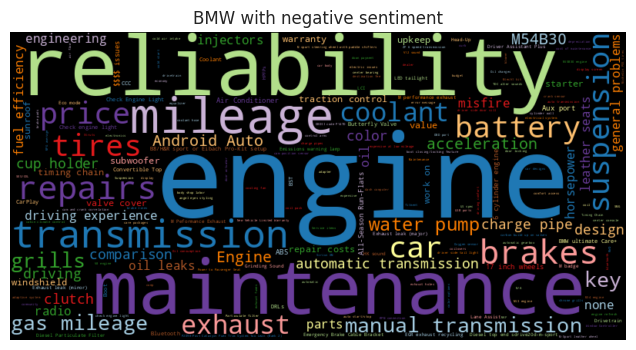

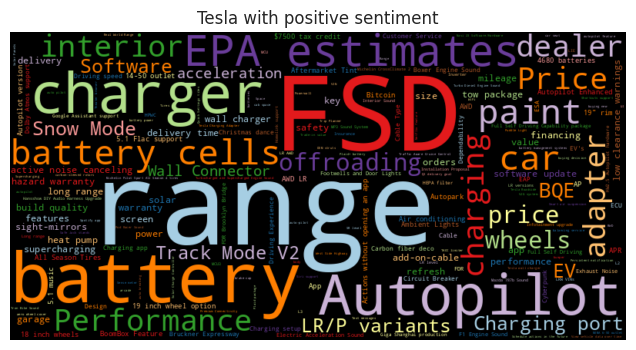

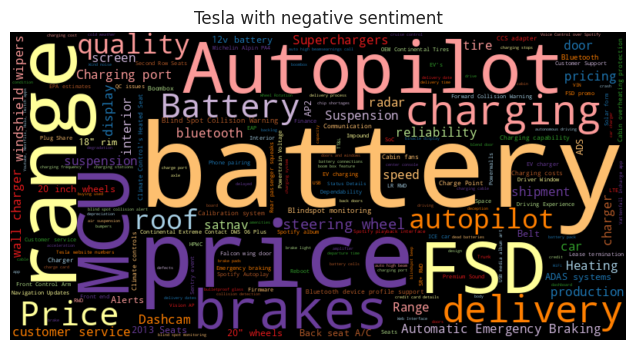

In [52]:
for vendor in ['Volkswagen', 'BMW', 'Tesla']:
    for sentiment in ['positive', 'negative']:

        tmp_df = sent_df.query('vendor == @vendor') \
                        .query('sentiment == @sentiment')

        # tmp_df = tmp_df.query('model.str.contains("Golf")')
        part_counts = tmp_df.groupby('part').id.count()
        wordcloud(part_counts, title=f"{vendor} with {sentiment} sentiment")
        plt.show()